# Fit Inspection

This notebook inspects fit results and allows the reader to manually specify new priors for any bad fits. It is important to note that manually specifying new priors will **NOT** update the fit results saved to file. New fit results can only be tabulated by re-running the analysis piepline.


In [1]:
import sys
from copy import deepcopy

import pandas as pd
import sncosmo
from SNData.csp import dr3
from SNData.des import sn3yr
from SNData.sdss import sako18
from astropy.table import Column, Table, unique
from matplotlib import pyplot as plt

sys.path.insert(0, '../')
from analysis_pipeline import get_priors, get_fit_results, split_data, fit_lc, SN91bgSource, save_priors


We first ensure that data is available on the local machine and the the filters for each survey are registered with SNComso.

In [2]:
# Download data and register SNCosmo filters
for data in (dr3, sn3yr, sako18):
    data.download_module_data()
    data.register_filters(force=True)

# Define models
salt2_4 = sncosmo.Model('salt2')
sn91bg = sncosmo.Model(SN91bgSource())


Next we define a function for viewing fit results.

In [3]:
def plot_lightcurves(obj_id, module, model, fit_results):
    """Plot a light curve
    
    Args:
        obj_id           (str): Survey specific object id
        module       (module): SNData submodule for a survey's data release
        model          (Model): The model to plot
        results_df (DataFrame): Pipeline fit results
    """

    data = [module.get_data_for_id(obj_id, format_sncosmo=True)]
    data += split_data(data[0], module.band_names, module.lambda_effective)
    for data_table, df in zip(data, fit_results):
        fit_results = df.loc[obj_id]

        model = deepcopy(model)
        params = {p: fit_results[p] for p in model.param_names}
        model.update(params)

        sncosmo.plot_lc(data_table, model)
        plt.show()


## Inspecting fit results

We specify the data module, light-curve model, and number of parameters we wish to inspect fits for. Using that information we build an iterator of object id values. To optionally skip ahead and start inspecting at a given object ID, specify the `start_at_id` variable. 

In [4]:
# Specify values in this code block
module_to_inspect = dr3
start_at_id = '2005kc'
model_to_inspect = salt2_4
params_to_inspect = 4

# Read in data and build iterator of object ids
priors = get_priors(module_to_inspect, model_to_inspect)
fits = get_fit_results(module_to_inspect, model_to_inspect, params_to_inspect)
ids = module_to_inspect.get_available_ids()
if start_at_id:
    ids = ids[ids.index(start_at_id):]

ids = iter(ids)


The following cell retrieves the next ID value and plots the the current fit results. If the fits look good, rerun the cell and move on to the next object. Otherwise, continue on to the following cells below.

Inspecting 2005kc


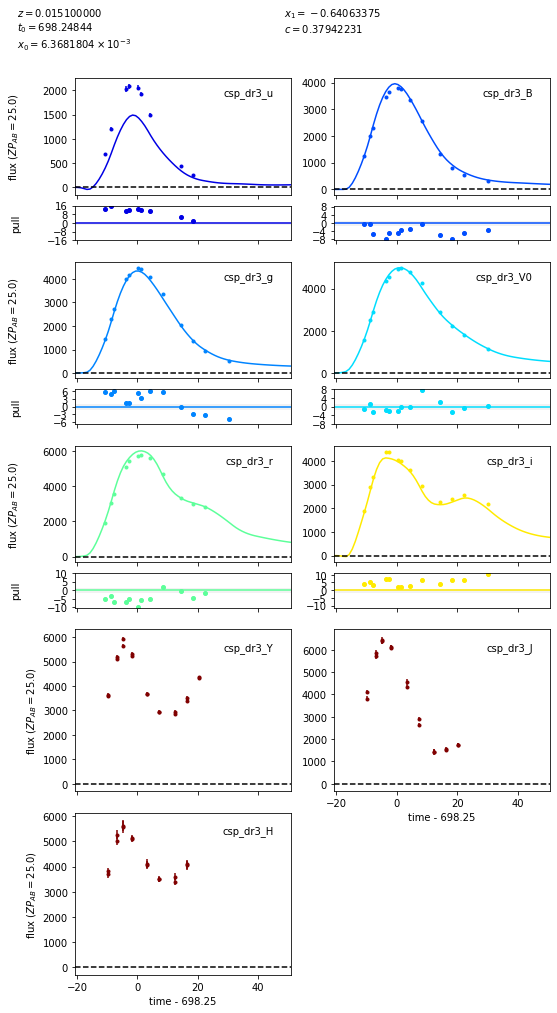

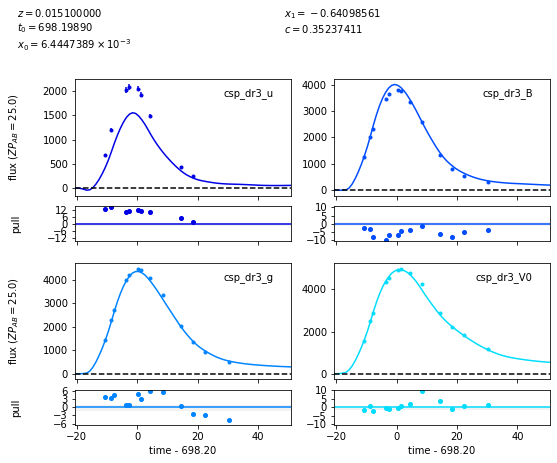

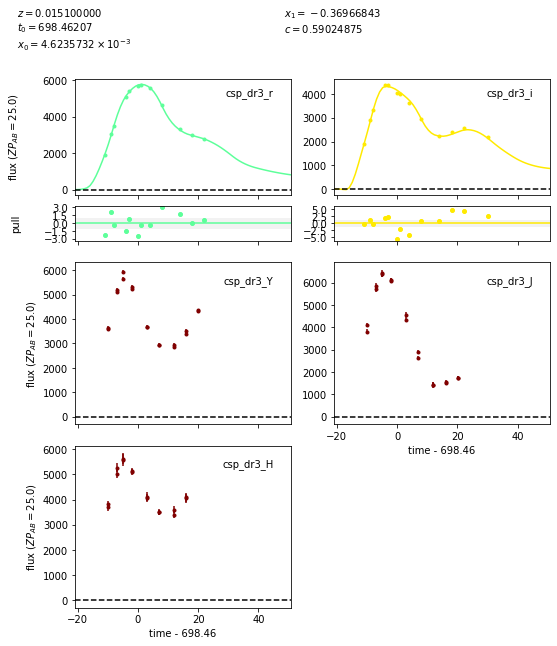

In [5]:
# Plot fits
current_id = next(ids)
print(f'Inspecting {current_id}')
plot_lightcurves(current_id, module_to_inspect, model_to_inspect, fits)


Take note of the priors used in the fit.

In [6]:
# Print priors
priors_this = priors.loc[current_id]
priors_dict = dict(priors_this)
print(priors_this)


z              0.0151
z_min          0.0035
z_max           0.084
t0            698.248
t0_min         672.52
t0_max         712.52
x0         0.00636616
x0_min              0
x0_max           0.05
x1          -0.640167
x1_min             -5
x1_max              5
c            0.379598
c_min              -1
c_max               1
message       Success
Name: 2005kc, dtype: object


Next we pick the portion of the light curve that was fit poorly, update the priors, and look at the new fit results.

In [ ]:
data_to_fit = 'all'  # 'all', 'blue', or 'red'

# Modify any values as you see fit:
#priors_dict['t0_min'] = 950
# priors_dict['t0_max'] = 1000
# priors_dict['t0_max'] = 1008
#priors_dict['c_max'] = 245


In [ ]:
# This cell reruns fits with the new priors and plots the results.
# There is no need to edit this cell.

# Get the specified bands of the lightcurve
data = module_to_inspect.get_data_for_id(current_id, format_sncosmo=True)
blue, red = split_data(
    data,
    module_to_inspect.band_names, 
    module_to_inspect.lambda_effective)

data = {'all': data, 'blue': blue, 'red': red}[data_to_fit]

# Set initial values in model
model_this = deepcopy(model_to_inspect)
vparams = model_to_inspect.param_names[5 - params_to_inspect:]
model_this.update({p: priors_dict[p] for p in vparams})
if 'z' not in vparams:
    model_this.set(z=data.meta['redshift'])

# Specify fitting bounds
bounds = None
bounds = {p: (priors_dict[f'{p}_min'], priors_dict[f'{p}_max']) for p in model_to_inspect.param_names}

fit_results = fit_lc(data, model_this, vparams, bounds=bounds)
z =  fit_results[2]
t0 = fit_results[3]
x0 = fit_results[4]
x1 = fit_results[5]
c = fit_results[6]
model_this.set(z=z, t0=t0, x0=x0, x1=x1, c=c)

sncosmo.plot_lc(data, model_this)
plt.show()
print(priors_dict)


If the new fits look good (enough), save the priors to file.

In [ ]:
save_priors(current_id, module_to_inspect, model_to_inspect, priors_dict, "Increased t0_min")